In [2]:
library(TreePar)
library(TreeSim)
library(NELSI)
library(doParallel)
library(foreach)

In [131]:
set.seed(10)
nspecies <- 50
time <- c(0, 0.5)
rho <- c(0.5, 1)
lambda <- c(1.5, 4)
mu <- c(1.5, 1)
rateshift_trees <- sim.rateshift.taxa(nspecies, 5, lambda = lambda, 
                                     mu = mu, frac = rho, times = time, complete = F)

[1] 1.870599 1.289996 1.699949 2.319481 2.170805


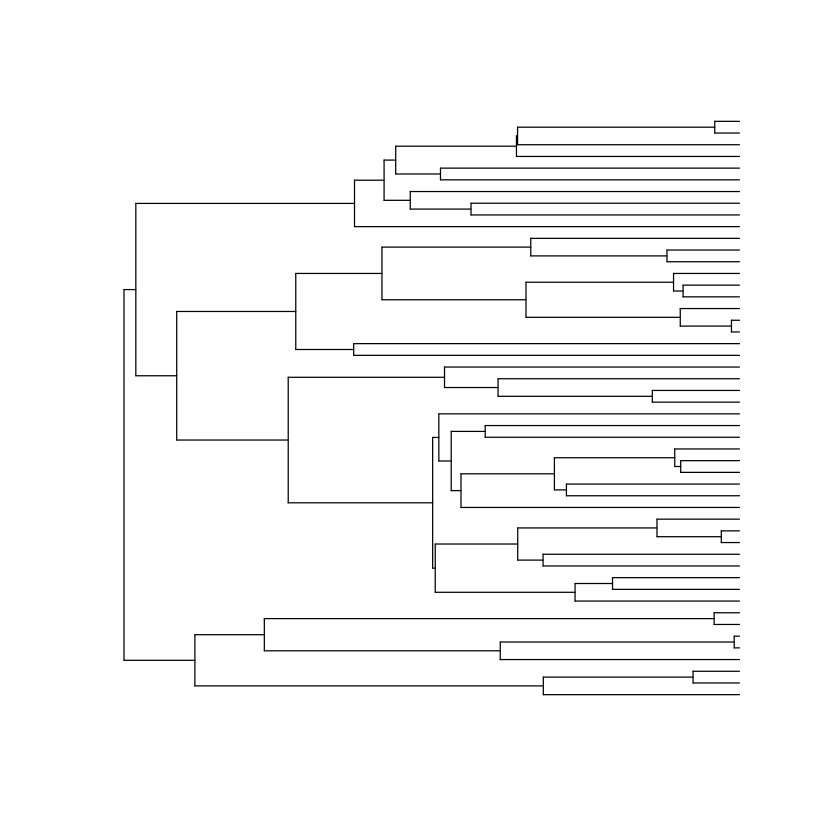

In [132]:
plot(rateshift_trees[[1]], show.tip.label = F)
#nodelabels(round(intnode.times(rateshift_trees[[1]]), 2))
print(  sapply(rateshift_trees, function(x) max(intnode.times(x)))  )

In [133]:
# Check that the rateshifts can be estimated
tr <- rateshift_trees[[2]]
x_times <- sort(intnode.times(tr), decreasing = T)
start <- min(x_times)
end <- max(x_times)
grid <- diff(range(x_times))
res <- bd.shifts.optim(x_times, sampling = c(0.5, 1), grid, start, end, posdiv = T)

[1] "startest"
[1] "test"
[1] 1.00000000 0.04847673
[1] 2.352029e+01 1.350112e-01 2.946875e-08 6.559245e-01 2.281883e+00
[6] 4.847673e-02
[1] 1.000000 1.289996
[1] 2.443422e+01 6.989068e-10 7.238397e-02 2.171516e+00 2.243899e+00
[6] 1.289996e+00
[[1]]
[1] 2.443422e+01 1.806960e-07 2.171516e+00

[[2]]
[1] 2.352029e+01 1.350112e-01 2.946875e-08 6.559245e-01 2.281883e+00
[6] 4.847673e-02



In [134]:
res[[2]]

[[1]]
[1] 2.443422e+01 1.806960e-07 2.171516e+00

[[2]]
[1] 2.352029e+01 1.350112e-01 2.946875e-08 6.559245e-01 2.281883e+00
[6] 4.847673e-02

In [90]:
fit_rate_shifts <- function(tree, rho){ # Rho at present.

    x_times <- sort(intnode.times(tree), decreasing = T)
    start <- min(x_times)
    end <- max(x_times)
    grid <- diff(range(x_times))
    res <- bd.shifts.optim(x_times, c(rho, 1), grid, start, end, posdiv = T)[[2]]

    # Find likelihoods, lambda, mu, and rate-shift times
    likelihoods <- sapply(res, function(x) x[1]) 
    
    lambda0 <- res[[1]][3] / (1 - res[[1]][2]) # These are the lambda and mu estimates from turover and net 
    mu0 <- lambda0 * res[[1]][2]               # speciation for 0 rate shifts. Please check.
   
    # The following are also computed, but note that some of them are negative and that this might. 
    # I couldn't simulate trees using these parameters, maybe because of the negative values?
    lambda11 <- res[[2]][3] / (1 - res[[2]][2])
    mu11 <- lambda11 * res[[2]][2]
    lambda12 <- res[[2]][5] / (1 - res[[2]][4])
    mu12 <- lambda12 * res[[2]][4]
    time1 <- res[[2]][length(res[[2]])]
        
 #   lambda21 <- res[[3]][3] / (1 - res[[3]][2])
 #   mu21 <- lambda21 * res[[2]][2]
 #   lambda22 <- res[[3]][5] / (1 - res[[3]][4])
 #   mu22 <- lambda22 * res[[3]][4]
 #   lambda23 <- res[[3]][7] / (1 - res[[3]][6])
 #   mu23 <- lambda23 * res[[3]][6]
 #   time2 <- res[[3]][(length(res[[3]]) - 2):length(res[[3]])]
    
    return(list(likelihoods, shifts0= c(lambda0, mu0), shifts1=c(lambda11, lambda12, mu11, mu12, time1)))
}

In [91]:
pvals <- vector()
likelihoods_distros <- list()
likelihoods_empirical <- vector()
empirical_tree_param_estimates <- list()

cl <- makeCluster(8)
registerDoParallel(cl)
for(tr in 1:length(rateshift_trees)){
    x_times <- sort(intnode.times(rateshift_trees[[tr]]), decreasing = T)
    start <- min(x_times)
    end <- max(x_times)
    grid <- diff(range(x_times))
    
    reference_estimates <- fit_rate_shifts(rateshift_trees[[tr]], 0.5)

    sim_trees0 <- sim.bd.taxa(n = nspecies, numbsim = 100, lambda = reference_estimates$shifts0[1], 
                              mu = reference_estimates$shifts0[2], frac = 0.5, complete = F)
    liks_sim_trees0 <- foreach(mt = sim_trees0, .packages = c('NELSI', 'TreePar')) %dopar% fit_rate_shifts(mt, 1)[[1]][1]
    likelihoods_distros[[tr]] <- liks_sim_trees0
    likelihoods_empirical[tr] <- reference_estimates[[1]][1]
    empirical_tree_param_estimates[[tr]] <- reference_estimates$shifts0
    pvals[tr] <- sum(reference_estimates[[1]][1] > liks_sim_trees0)

}
stopCluster(cl)

[1] "startest"
[1] "test"
[1] 1.000000000 0.003238663
[1] 4.370578e+02 9.999212e-01 9.647806e-04 1.066341e-04 1.480285e+00
[6] 3.238663e-03
[1] 1.000000 2.391546
[1] 4.372284e+02 6.923085e-08 4.943920e-02 1.483163e+00 1.532601e+00
[6] 2.391546e+00
[[1]]
[1] 4.372284e+02 4.832540e-07 1.483162e+00

[[2]]
[1] 4.370578e+02 9.999212e-01 9.647806e-04 1.066341e-04 1.480285e+00
[6] 3.238663e-03

[1] "startest"
[1] "test"
[1] 1.000000000 0.007803738
[1] 4.376187e+02 9.998157e-01 1.014606e-04 1.031156e-04 1.472731e+00
[6] 7.803738e-03
[1] 1.000000 2.419701
[1] 4.387622e+02 2.882771e-08 2.882771e-08 1.479236e+00 1.479236e+00
[6] 2.419701e+00
[[1]]
[1] 4.387622e+02 2.882771e-08 1.479236e+00

[[2]]
[1] 4.376187e+02 9.998157e-01 1.014606e-04 1.031156e-04 1.472731e+00
[6] 7.803738e-03

[1] "startest"
[1] "test"
[1] 1.000000000 0.001775659
[1] 4.657811e+02 9.999233e-01 3.326924e-05 1.929078e-04 1.397018e+00
[6] 1.775659e-03
[1] 1.000000 3.037333
[1] 4.660478e+02 4.146984e-08 4.658101e-02 1.397427e+00 

ERROR: Error in likelihoods_distros[[i]]: subscript out of bounds


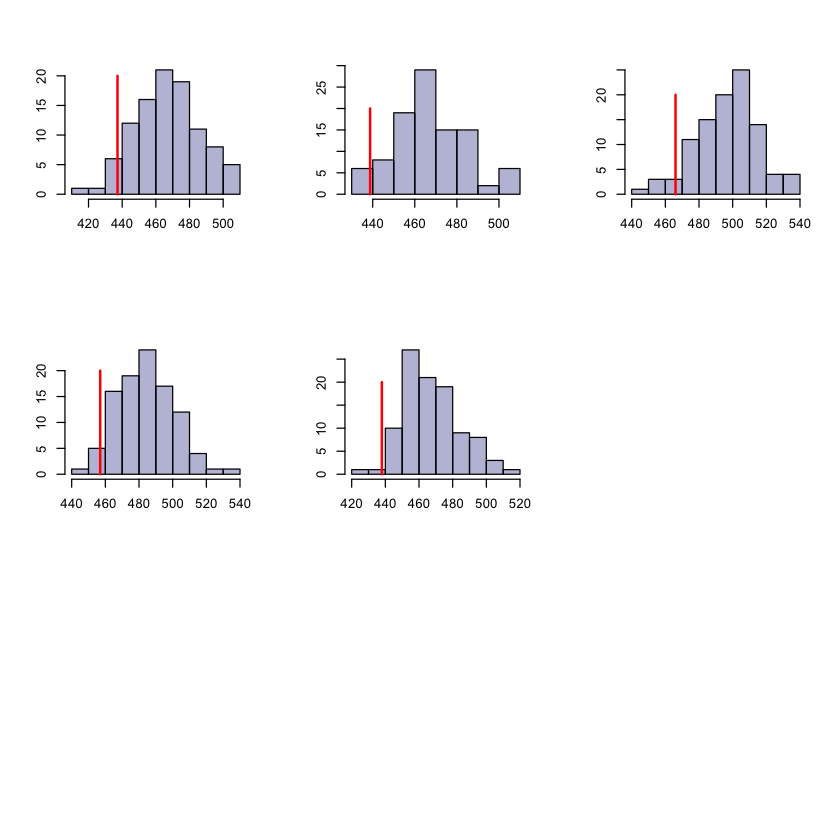

In [92]:
par(mfrow = c(3, 3))
for(i in 1:9){
    hist(as.numeric(likelihoods_distros[[i]]), main = '', ylab = '', xlab = '', col = rgb(0, 0, 0.5, 0.3))
    lines(x = c(likelihoods_empirical[i], likelihoods_empirical[i]), y = c(0, 20), col = 'red', lwd = 2)
}

In [93]:
pvals/100

[1] 0.06 0.04 0.06 0.04 0.02

In [137]:
# First we simulate a tree, and then estimate the parameters for the tree:
# Number of species
nspecies <- 20
# At time 1 and 2 in the past, we have a rate shift:
time <- c(0,1)
# Mass extinction intensities 0.5 at time 1 in past, 0.4 at time 2 in past. 
# Present day species are all sampled (rho[1]=1):
rho <- c(1,0.5)
# speciation rates (between t[i],t[i+1] we have speciation rate lambda[i]):
lambda <- c(2,2)
# extinction rates (between t[i],t[i+1] we have extinction rate mu[i]):
mu <- c(1,1)
# Simulation of a tree:
tree<-sim.rateshift.taxa(nspecies,1,lambda,mu,frac=rho,times=time,complete=FALSE)
# Extracting the speciation times x:
x<-sort(getx(tree[[1]]),decreasing=TRUE)

# When estimating the the rate shift times t based on branching times x, 
# we allow the shift times to be 0.6, 0.8, 1, 1.2, .. ,2.4:
start <- 0.6
end <- 2.4
grid <- 0.2


# We fix rho and estimate time, lambda, mu:
res <- bd.shifts.optim(x,rho,grid,start,end)[[2]]
res
# res[[2]] tells us about the maximum likelihood estimate given one rate shift:
# - log lik = 17.330862988.
# rate shift at time 2.2.
# turnover (extinction/speciation) = 0.186301549 more recent than 2.2,
#     and = 0.939681843 more ancestral than 2.2.
# net diversification (speciation-extinction) rate = 0.958947381 more recent than 2.2, 
#     and = 0.000100009 more ancestral than 2.2.


[1] "startest"
[1] "test"
[1] 1.0 0.6
[1] 3.2138582 0.7739389 0.9493499 0.8486191 0.3999942 0.6000000
[1] 1.0 0.8
[1]  2.4830331  0.8478191  1.1674072  0.5885947 -5.2471946  0.8000000
[1] 1 1
[1] 2.1939558923 0.5651497865 0.3592272227 1.4607845464 0.0001000113
[6] 1.0000000000
[1] 1.0 1.2
[1] 2.7863321388 0.7102205674 0.2456755204 1.0490232009 0.0001001953
[6] 1.2000000000
[1] 1.0 1.4
[1] 3.2217587 0.8045236 0.8314022 0.7464460 0.7727556 1.4000000
[1] 1.0 1.6
[1] 3.2217587 0.8045236 0.8314022 0.7464460 0.7727556 1.6000000
[1] 1.0 1.8
[1] 3.2217587 0.8045236 0.8314022 0.7464460 0.7727556 1.8000000
[1] 1 2
[1] 3.2217587 0.8045236 0.8314022 0.7464460 0.7727556 2.0000000
[1] 1.0 2.2
[1] 3.2217587 0.8045236 0.8314022 0.7464460 0.7727556 2.2000000
[1] 1.0 2.4
[1] 3.2217587 0.8045236 0.8314022 0.7464460 0.7727556 2.4000000
[[1]]
[1] 3.2217588 0.8046712 0.7460245

[[2]]
[1] 2.1939558923 0.5651497865 0.3592272227 1.4607845464 0.0001000113
[6] 1.0000000000



[[1]]
[1] 3.2217588 0.8046712 0.7460245

[[2]]
[1] 2.1939558923 0.5651497865 0.3592272227 1.4607845464 0.0001000113
[6] 1.0000000000